<h1 align="center">Pupil detection using DL</h1>

<h2 align="left">Pupil detection using DL:</h2>
    
Eye tracking systems and measurement of the size and position of the pupil are widely used in various fields of medical research (psychological, neurophysiological, cognitive, ophthalmological).

Such measurements are usually carried out in laboratory settings, where the most commonly used systems are video oculography systems, which use video cameras to capture images of the eyes under a fixed illumination, from a fixed distance.

However, pupil measurement is of potentially greater significance. For example, to assess a person's fatigue. But the question arises, how to carry out these measurements? You will not equip mobile pupillometric stations for this purpose.

Therefore, it is currently considered an urgent task to create systems that would allow the use of household cameras (in a phone, in a watch, webcams) to obtain data and estimate the size of the pupil.

To date, there is no single approach. If you find a lot of ready-made solutions, incl. based on neural networks that would allow segmenting the eye, or the iris (for example, the solution from Gooogle - Mediapipe) is quite simple, then there are no ready-made models for segmenting the pupil.

<h2 align="left">Aim of this work:</h2>

Create an ML model for taking a pupil measurement (pupillogram) in the incoming streaming video, which is a video recording of the entire face. Becouse left and right pupils contract and dilate simultaniously (pupil reflex) we will select only left eye to make calculations simplier.

# Part 1 - Dataset preparation

No ready-made datasets were found on the network. To carry out this work, I took a ready-made set from Nvidia, NVGaze, which was created to assess the direction of view. On which the pupil is selected with the help of gradients and its coordinates and radius are obtained. The resulting vector [X,Y,R] will later be used to train the neural network.

##### Required imports

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import seaborn as sns


pd.set_option('display.max_rows', 30)

##### Upload csv file with links to source images.

In [4]:
df = pd.read_csv('eyes.csv')

In [5]:
df

,imagefile,eye
0,D:\Eyes dataset\13\000001.jpg,L
1,D:\Eyes dataset\13\000002.jpg,L
2,D:\Eyes dataset\13\000003.jpg,L
3,D:\Eyes dataset\13\000004.jpg,L
4,D:\Eyes dataset\13\000005.jpg,L
...,...,...
336166,D:\Eyes dataset\17\070457.jpg,R
336167,D:\Eyes dataset\17\070458.jpg,R
336168,D:\Eyes dataset\17\070459.jpg,R
336169,D:\Eyes dataset\17\070460.jpg,R


#### Original image
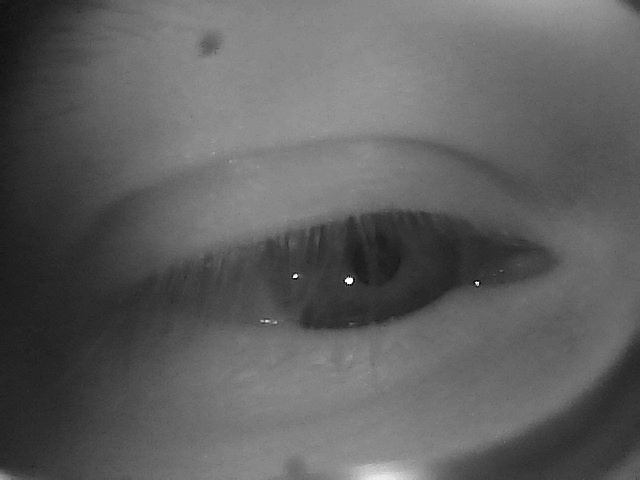

#### Let's determine the position of the pupil on the original images using the work with trashholds. Get the coordinates of the pupil center and its radius. For visual evaluation, we will also save a copy of the image with the selected pupil

In [ ]:
df_03_normalized_set_pupils_marked = pd.DataFrame()

for x in tqdm(range (len(df))):
    
    path = df.iloc[x]['path']
    side = df.iloc[x]['eye']
    
    image = cv2.imread(path)
    
    row, col, _ = image.shape #Get the width and height of the selected fragment
    gray_roi = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #Grayscale Conversion
    gray_roi = cv2.GaussianBlur (gray_roi, (33, 33), 0) #Smoothing out the image
    __, threshold = cv2.threshold (gray_roi, 40, 255, cv2.THRESH_BINARY) #Cut off by thrashhold
    contours, __ = cv2.findContours (threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) #We use the function to search for 
                                                                                      #the contours of objects after selecting 
                                                                                      #them by the threshold
    contours = sorted (contours, key = lambda x: cv2.contourArea(x), reverse = True)  #Sort all the contours from largest to smallest
                                                                                          
    try:
        os.remove(path[:-3] + 'jpeg')
    except:
        None
        
    for cnt in contours:
        if cv2.contourArea(cnt)>400 and cv2.contourArea(cnt)<15000: #leave in the area only what looks like a pupil
            (x,y), r = cv2.minEnclosingCircle(cnt)
            x=int(x)
            y=int(y)
            r = int(r)
            
            cv2.circle (image, (x,y), r, (255,255,0), 2)
            filename_png = path[:-3] + 'jpeg'
            cv2.imwrite(filename_png, image)
            
            data = pd.DataFrame({'eye':     [str(side)],
                                 'path':    [str(path)],
                                 'im_h(y)': [int(row)],
                                 'im_w(x)': [int(col)],
                                 'pupil_x': [int(x)],
                                 'pupil_y': [int(y)],
                                 'pupil_r': [int(r)] })
            
            df_03_normalized_set_pupils_marked = pd.concat([df_03_normalized_set_pupils_marked,data], axis=0);
            
df_03_normalized_set_pupils_marked.to_csv('df_03_normalized_set_pupils_marked.csv',
              index=False)

##### An example of an image with a selected pupil
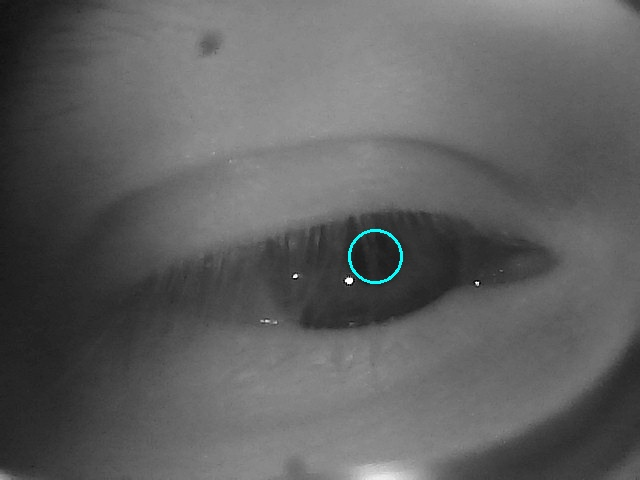

#### View of the table after the completion of the algorithm

In [226]:
df = pd.read_csv ('df_03_normalized_set_pupils_marked.csv')
df

,eye,path,im_h(y),im_w(x),pupil_x,pupil_y,pupil_r
0,L,D:\Eyes dataset\01.Normalized\13\000001.jpg,480,640,375,256,26
1,L,D:\Eyes dataset\01.Normalized\13\000002.jpg,480,640,375,257,26
2,L,D:\Eyes dataset\01.Normalized\13\000003.jpg,480,640,375,257,27
3,L,D:\Eyes dataset\01.Normalized\13\000004.jpg,480,640,375,255,27
4,L,D:\Eyes dataset\01.Normalized\13\000005.jpg,480,640,375,256,26
...,...,...,...,...,...,...,...
330578,R,D:\Eyes dataset\01.Normalized\17\070457.jpg,480,640,327,162,26
330579,R,D:\Eyes dataset\01.Normalized\17\070458.jpg,480,640,328,161,26
330580,R,D:\Eyes dataset\01.Normalized\17\070459.jpg,480,640,328,161,25
330581,R,D:\Eyes dataset\01.Normalized\17\070460.jpg,480,640,327,161,25


#### Dataset сleaning:

After the algorithm has run, the set contains various variants of incorrectly selected images. For example, several pupils in the photo and an abnormally large pupil are highlighted. Therefore, we will clean up the set

In [227]:
##### Throw out duplicates. Those images where multiple centers were found.
df.drop(df[df.path.duplicated(keep=False)].index, inplace=True)

<AxesSubplot: >

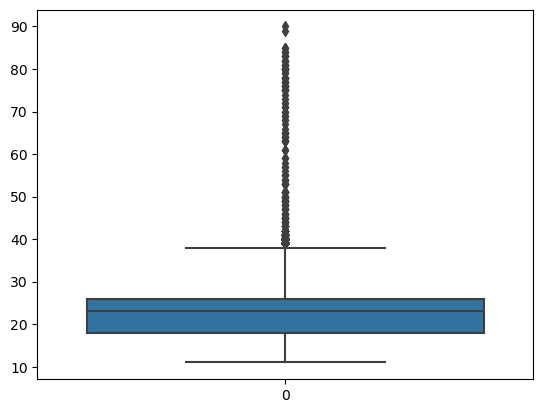

In [229]:
##### Let's check the pupil size distribution in the set.
sns.boxplot(df.pupil_r)

In [255]:
##### Remove explicit outliers
df.drop(df[df.pupil_r>38].index, inplace=True)

In [257]:
df.to_csv('df_04_normalized_set_pupils_marked_wo_outliers.csv',
              index=False)

##### Starting from the center of the pupil, select the iris. As a formula, we use empirically selected parameters: from the coordinates of the pupil, we capture 108 pixels on the left and right, 96 pixels on top, 120 on the bottom. And repeat all steps of pupil selection and dataset cleaning to mantain better result and dataset quality

In [280]:
df=pd.read_csv('df_04_normalized_set_pupils_marked_wo_outliers.csv')

In [304]:
df_05_normalized_iris_set = pd.DataFrame()

for x in tqdm(range (len(df))):
    
    side = df.iloc[x]['eye']
    path = df.iloc[x]['path']
    pupil_x=df.iloc[x]['pupil_x']
    pupil_y=df.iloc[x]['pupil_y']
    
    image = cv2.imread(path)
        
    name = str(path).split('\\')[-1]
    collection_name = str(path).split('\\')[-2]
    
    new_path = 'D:\\Eyes dataset\\02.Iris_set\\' + collection_name + '\\' + name
    
    try:
        os.remove(new_path)
    except:
        None 
    
    h,w,_ = image.shape
    corr_h = 120# int(0.2*h)
    corr_w = 120# int(0.2*w)

    y1=pupil_y-int(0.8*corr_h)
    y2=pupil_y+corr_h
    x1=pupil_x-int(0.9*corr_w)
    x2=pupil_x+int(0.9*corr_w)

    iris_roi = image[y1:y2, 
                     x1:x2]
    
    cv2.imwrite(new_path, iris_roi)
        
    data = pd.DataFrame({'eye':[str(side)],
                         'path': [str(new_path)]})      
    
    df_05_normalized_iris_set = pd.concat([df_05_normalized_iris_set, data], axis=0);
            
df_05_normalized_iris_set.to_csv('df_05_normalized_iris_set.csv',
                                  index=True)

100%|██████████| 282633/282633 [1:26:30<00:00, 54.46it/s]  


##### Image example after highlighting the iris

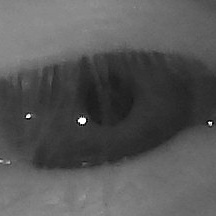

##### Again, we calculate the radius and coordinates of the pupil in the set with only irises.

In [305]:
df = pd.read_csv ('df_05_normalized_iris_set.csv')

In [306]:
df

,Unnamed: 0,eye,path
0,0,L,D:\Eyes dataset\02.Iris_set\13\000001.jpg
1,0,L,D:\Eyes dataset\02.Iris_set\13\000002.jpg
2,0,L,D:\Eyes dataset\02.Iris_set\13\000003.jpg
3,0,L,D:\Eyes dataset\02.Iris_set\13\000004.jpg
4,0,L,D:\Eyes dataset\02.Iris_set\13\000005.jpg
...,...,...,...
282628,0,R,D:\Eyes dataset\02.Iris_set\17\070457.jpg
282629,0,R,D:\Eyes dataset\02.Iris_set\17\070458.jpg
282630,0,R,D:\Eyes dataset\02.Iris_set\17\070459.jpg
282631,0,R,D:\Eyes dataset\02.Iris_set\17\070460.jpg


In [313]:
df_06_normalized_iris_set_w_pupils = pd.DataFrame()

for x in tqdm(range (len(df))):
    
    path = df.iloc[x]['path']
    side = df.iloc[x]['eye']
    
    image = cv2.imread(path)
    row, col, _ = image.shape
    gray_roi = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_roi = cv2.GaussianBlur (gray_roi, (33, 33), 0)
    __, threshold = cv2.threshold (gray_roi, 40, 255, cv2.THRESH_BINARY)
    contours, __ = cv2.findContours (threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) 
    contours = sorted (contours, key = lambda x: cv2.contourArea(x), reverse = True)
    try:
        os.remove(path[:-3] + 'jpeg')
    except:
        None
    for cnt in contours:
        if cv2.contourArea(cnt)>400 and cv2.contourArea(cnt)<15000:
            (x,y), r = cv2.minEnclosingCircle(cnt)
            x=int(x)
            y=int(y)
            r = int(r)
            
            cv2.circle (image, (x,y), r, (255,255,0), 2)
            filename_png = path[:-3] + 'jpeg'
            cv2.imwrite(filename_png, image)
            
            data = pd.DataFrame({'eye':     [str(side)],
                                 'path':    [str(path)],
                                 'im_h(y)': [int(row)],
                                 'im_w(x)': [int(col)],
                                 'pupil_x': [int(x)],
                                 'pupil_y': [int(y)],
                                 'pupil_r': [int(r)] })
            df_06_normalized_iris_set_w_pupils = pd.concat([df_06_normalized_iris_set_w_pupils,data], axis=0);
df_06_normalized_iris_set_w_pupils.to_csv('df_06_normalized_iris_set_w_pupils.csv',
                                          index=False)

100%|██████████| 282633/282633 [1:18:12<00:00, 60.23it/s]


##### View of the image after highlighting the iris and marking the pupil

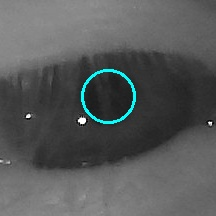

#### Cleaning up the data again

In [314]:
df_06_normalized_iris_set_w_pupils = pd.read_csv('df_06_normalized_iris_set_w_pupils.csv')

In [320]:
dupl = df_06_normalized_iris_set_w_pupils[df_06_normalized_iris_set_w_pupils['path'].duplicated (keep=False)].index
df_06_normalized_iris_set_w_pupils.drop(dupl, inplace=True)
df_06_normalized_iris_set_w_pupils.to_csv('df_06_normalized_iris_set_w_pupils.csv', index=False)

<AxesSubplot: >

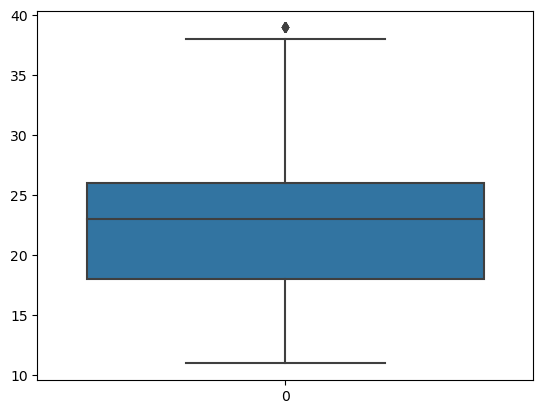

In [338]:
sns.boxplot(df_06_normalized_iris_set_w_pupils.pupil_r)

#### Pupil size distribution in the final set

<AxesSubplot: xlabel='pupil_r', ylabel='Count'>

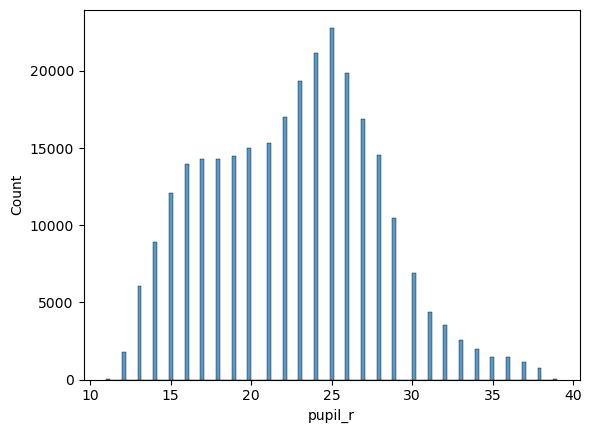

In [343]:
sns.histplot(df_06_normalized_iris_set_w_pupils.pupil_r)

In [354]:
df_06_normalized_iris_set_w_pupils[df_06_normalized_iris_set_w_pupils.pupil_r>=38]

,eye,path,im_h(y),im_w(x),pupil_x,pupil_y,pupil_r
148,L,D:\Eyes dataset\02.Iris_set\13\000306.jpg,216,216,108,96,38
155,L,D:\Eyes dataset\02.Iris_set\13\000313.jpg,216,216,108,96,38
158,L,D:\Eyes dataset\02.Iris_set\13\000316.jpg,216,216,108,96,38
159,L,D:\Eyes dataset\02.Iris_set\13\000317.jpg,216,216,108,96,38
160,L,D:\Eyes dataset\02.Iris_set\13\000318.jpg,216,216,107,96,38
...,...,...,...,...,...,...,...
182901,L,D:\Eyes dataset\02.Iris_set\16\023760.jpg,216,216,108,96,38
184585,R,D:\Eyes dataset\02.Iris_set\16\026238.jpg,216,215,108,96,38
187643,L,D:\Eyes dataset\02.Iris_set\16\030708.jpg,216,213,109,97,38
210038,R,D:\Eyes dataset\02.Iris_set\16\060077.jpg,216,213,108,97,38


In [352]:
df_06_normalized_iris_set_w_pupils.drop([196967,210620,215005], axis=0, inplace=True)

In [356]:
df_06_normalized_iris_set_w_pupils.to_csv('df_06_normalized_iris_set_w_pupils.csv', index=False)

# Part 2 - Training the model:

Initially, the idea was to apply the resulting model in mobile devices, the computing power of which is still not as great as that of personal computers. Therefore, I consider grayscale images as input data.

Since almost all pre-trained models such as VGG16, VGG19, ResNET, MobilNET are pre-trained for three-band images, in this work I used my own convolutional model and trained it.

#### Required imports

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, AveragePooling2D, GlobalMaxPool2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model

import gc

In [ ]:
#### Функция для построения графика обучения на тренировочном и обучающем наборе:
def test_val_graph (history,train,val):
    plt.plot(history.history[train], label='Точность на обучающем наборе')
    plt.plot(history.history[val], label='Точность на проверочном наборе')
    plt.xlabel('Цикл обучения')
    plt.ylabel('Точность')
    plt.legend()
    plt.show()
    pass;

#### Create training sets

In [ ]:
df = pd.read_csv ('df_06_normalized_iris_set_w_pupils.csv')

In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=43) #

In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.3)
test_datagen=ImageDataGenerator(rescale=1./255.)

In [ ]:
TARGET_SIZE = (216,216)
COLOR_MODE = "grayscale"
BATCH_SIZE = 10

train_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="path",
y_col=["pupil_x","pupil_y","pupil_r"],
subset="training",
batch_size=BATCH_SIZE,
seed=42,
shuffle=True,
class_mode="raw",
color_mode=COLOR_MODE,
target_size=TARGET_SIZE)

valid_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="path",
y_col=["pupil_x","pupil_y","pupil_r"],
subset="validation",
batch_size=BATCH_SIZE,
seed=42,
shuffle=True,
class_mode="raw",
color_mode=COLOR_MODE,
target_size=TARGET_SIZE)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory="./",
x_col="path",
y_col=["pupil_x","pupil_y","pupil_r"],
batch_size=BATCH_SIZE,
seed=42,
shuffle=False,
class_mode="raw",
color_mode=COLOR_MODE,
target_size=TARGET_SIZE)

#### Сreate the architecture of the model

In [ ]:
model_conv = Sequential()

model_conv.add (Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(216,216,1)))
model_conv.add (Conv2D(64, (3,3), padding='same', activation='relu'))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))
model_conv.add (BatchNormalization())
model_conv.add (Dropout(0.5))

model_conv.add (Conv2D(128, (3,3), padding='same', activation='relu'))
model_conv.add (Conv2D(128, (3,3), padding='same', activation='relu'))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))
model_conv.add (BatchNormalization())
model_conv.add (Dropout(0.5))

model_conv.add (Conv2D(256, (3,3), padding='same', activation='relu'))
model_conv.add (Conv2D(256, (3,3), padding='same', activation='relu'))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))
model_conv.add (BatchNormalization())
model_conv.add (Dropout(0.5))

model_conv.add (Conv2D(512, (3,3), padding='same', activation='relu'))
model_conv.add (Conv2D(512, (3,3), padding='same', activation='relu'))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))
model_conv.add (BatchNormalization())
model_conv.add (Dropout(0.5))

model_conv.add (Conv2D(1024, (3,3), padding='same', activation='relu'))
model_conv.add (Conv2D(1024, (3,3), padding='same', activation='relu'))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))
model_conv.add (BatchNormalization())
model_conv.add (Dropout(0.5))

model_conv.add(GlobalMaxPool2D())

model_conv.add(Dense(2000, activation='relu'))
model_conv.add (BatchNormalization())
model_conv.add (Dropout(0.5))

model_conv.add(Dense(2000, activation='relu'))
model_conv.add (BatchNormalization())
model_conv.add (Dropout(0.5))

model_conv.add(Dense(3, activation='relu')
               
model_conv.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

In [ ]:
checkpoint_cb_conv = ModelCheckpoint("own_model-LR-216_216_just_iris.h5", 
                                     monitor = 'val_mae',
                                     save_best_only=True)

lr_scheduler = ReduceLROnPlateau(factor=0.2, patience=2)

In [ ]:
history = model_conv.fit(train_generator,
                          validation_data=valid_generator,
                          callbacks=[checkpoint_cb_conv,lr_scheduler],
                          epochs=50)

In [ ]:
test_val_graph(history, 'mae', 'val_mae')

# Part 3 - Applying the resulting model:

As I pointed out at the beginning, there are many ready-made solutions for segmenting the eye and iris. Therefore, we use a ready-made tool from Google - Mediapipe. With the help of which we select the iris and feed it to the input of the model. At the output, we will get the vector [X, Y, R] with which it will be possible to select the pupil.

#### Required imports

In [ ]:
import mediapipe as mp
import cv2
import numpy as np
from tensorflow.keras.models import load_model
mp_face_mesh = mp.solutions.face_mesh

#### Loading the model

In [ ]:
model = load_model ('model\own_model-LR-216_216_just_iris.h5')
MODEL_X=216
MODEL_Y=216
MODEL_DEPTH=1

#### Function to select only the left iris

In [ ]:
def left_iris_roi(mesh_p, h,w):
    
    LEFT_IRIS_LEFT_CORNER = 474 ####LEFT
    LEFT_IRIS_RIGHT_CORNER = 476 ####RIGHT        
    LEFT_IRIS_UPPER_CORNER = 475 ####UP
    LEFT_IRIS_BOTTOM_CORNER = 477 ###DOWN
    
    CORR_Y = int(0.01*h) ### Correction factors
    CORR_X = int(0.01*w) ###

    from_y_left = mesh_p[LEFT_IRIS_UPPER_CORNER][1] - CORR_Y
    to_y_left = mesh_p[LEFT_IRIS_BOTTOM_CORNER][1] + CORR_Y
    
    from_x_left = mesh_p[LEFT_IRIS_RIGHT_CORNER][0] - CORR_X
    to_x_left = mesh_p[LEFT_IRIS_LEFT_CORNER][0] + CORR_X
    
    return from_y_left, to_y_left, from_x_left, to_x_left

#### Predict

In [ ]:
def predict(image, 
            model_x, 
            model_y,
            model_depth,
            verbose=0):
    
    image = image/255
    image = image.reshape(1, model_x, model_y, model_depth)
    x, y, r = model.predict(image, verbose=verbose).astype(int)[0]
    
    return x,y,r

#### A function that implements a pupillogram

In [ ]:
def pupillogram(FILE_NAME):
    
    print ('...initialize pupil capture')
    RADIUS_CHANGE = []
    cap = cv2.VideoCapture(FILE_NAME)
        
    with mp_face_mesh.FaceMesh(
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5) as face_mesh:
        
        print ('... starting pupil measurements')
        while cap.isOpened():
            success, image = cap.read()
        
            if not success
                break 
                
            h,w,_ = np.shape(image)   
           
                ### Point detection
            results = face_mesh.process(image)
        
            if results.multi_face_landmarks:
                ### Convert coordinates from relative to absolute values
                mesh_p = np.array([np.multiply([p.x, p.y], [w,h]).astype(int) for p in results.multi_face_landmarks[0].landmark])
            else:
                print ("Лицо не найдено")
            y1,y2,x1,x2 = left_iris_roi(mesh_p, h,w) ### Get iris coordinates
            roi_left = image [y1:y2,x1:x2]
            
                ##### Получаем предикт
            x,y,r = predict(roi_left,
                                 model_x=MODEL_X, 
                                 model_y=MODEL_Y,
                                 model_depth=MODEL_DEPTH)
                
                
            RADIUS_CHANGE.append(r) #### Array with pupil radius changes
                
            cv2.circle (corrected_img, (x,y), r, (255,255,0), 1)
            cv2.putText(corrected_img, 'Radius - ' + str(r) , (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                                        0.5, (255, 0, 0), 2, cv2.LINE_AA)
            
            cv2.imshow ('Full face', image)
            cv2.imshow ('Left Eye', corrected_img)
            
            key=cv2.waitKey(30)
            if key==27:
                break
            
    cap.release()
    cv2.destroyAllWindows()
    print ('... module completed\n')
    return RADIUS_CHANGE

In [ ]:
FILE = 'video\\temp.avi'
pupillogram(FILE)

##### Результат работы

##### Исходное видео
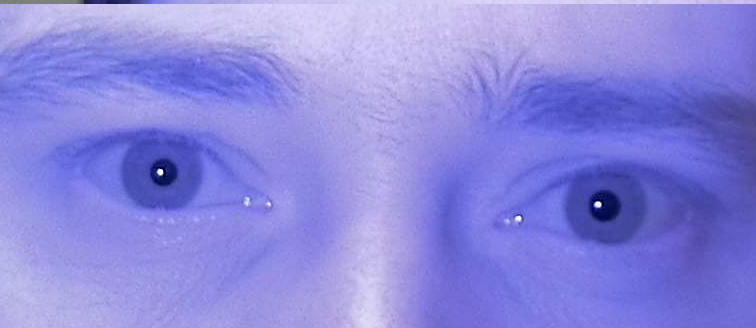

#### Выделенный зрачкок левого глаза и его радиус(в пикселях)

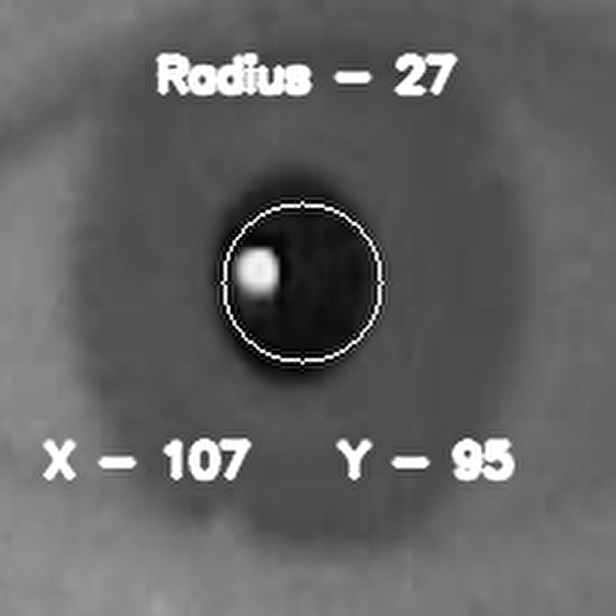


#### Conclusions:

This approach demonstrates one of the ways to use neural networks for image segmentation and object selection.

Of course, the result is not ideal, and in order to further improve the accuracy of the model, it is necessary to work with these data:
1. Increase the variety of the set, because all images in the used set are made in the same "refined" conditions, which will rarely be encountered in real life.
2. Carry out a manual deep cleaning, since the outlier and duplicate cut-off approach does not allow you to completely discard all incorrectly labeled images on the trashhold. However, doing this alone (in a set of about 270k images) is problematic

And, perhaps, try other model architectures.